In [2]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torch.optim.lr_scheduler import CosineAnnealingLR


from config import VitConfig
from model import VisionTransformer

In [3]:
import importlib
import model, config
importlib.reload(config)
importlib.reload(model)

from config import VitConfig
from model import VisionTransformer


In [4]:
config = VitConfig()
model = VisionTransformer(config)

In [5]:
transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((config.img_size,config.img_size))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# Create DataLoader for training and testing datasets
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False, num_workers=4)

In [ ]:
#CIFAR labels to human readable labels
CIFAR10_CLASSES = [
    'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
]
data = next(iter(train_loader))
images, labels = data

# Check the shape of the images and labels
print(f'Images shape: {images.shape}')
print(f'Labels shape: {labels.shape}')

#decode the first image

def imshow(img):
    npimg = img.numpy()
    plt.figure(figsize=(2, 2))  # keep this small to avoid blur
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')  # no interpolation
    plt.axis('off')
    plt.show()
print(CIFAR10_CLASSES[labels[0].item()])
print(images[0])
imshow(images[0])

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()
num_epochs = 50
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs * len(train_loader), eta_min=1e-6)
print(device)


cuda


In [ ]:
def train_epoch(epoch):
    model.train()
    all_preds = []
    all_labels = []
    total_loss = 0.0
    iter = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(images)
        preds = logits.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        print(f"[Epoch {epoch + 1}] Training Batch [{iter + 1}/{len(train_loader)}]: Loss {loss.item()}")
        iter += 1
    return total_loss / len(train_loader), all_preds, all_labels

In [ ]:
def eval_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    iter = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            print(f"Iteration [{iter}/{len(data_loader)}]", end="\r")
            iter += 1
    return all_preds, all_labels

def accuracy(all_preds, all_labels):
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    return (all_preds == all_labels).mean()

In [ ]:
for epoch in range(num_epochs):
    print(f"*********  Epoch {epoch + 1}/{num_epochs}  *********")
    train_loss, train_preds, train_labels = train_epoch(epoch)
    train_acc = accuracy(train_preds, train_labels)
    print(f"Epoch {epoch + 1} - Train Loss: {train_loss:.4f} - Train Accuracy: {train_acc:.4f}")

    test_preds, test_labels = eval_model(model, test_loader)
    test_acc = accuracy(test_preds, test_labels)
    print(f"Epoch {epoch + 1} - Test Accuracy: {test_acc:.4f}")

    torch.save(model.state_dict(), "vit-s.pth")

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("vit-s.pth"))
model = model.to(device)
model.eval()

# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

VisionTransformer(
  (embedding_layer): VitEmbeddingLayer(
    (patch_embedding): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (cls_embedding): Embedding(1, 384)
    (position_embedding): Embedding(257, 384)
  )
  (encoder): VitEncoder(
    (encoder): ModuleList(
      (0-11): 12 x VitEncoderBlock(
        (ln1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
        (attn): MultiHeadAttention(
          (Q): Linear(in_features=384, out_features=384, bias=True)
          (K): Linear(in_features=384, out_features=384, bias=True)
          (V): Linear(in_features=384, out_features=384, bias=True)
        )
        (ln2): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (linear1): Linear(in_features=384, out_features=1536, bias=True)
          (linear2): Linear(in_features=1536, out_features=384, bias=True)
        )
      )
    )
  )
  (mlp_head): Linear(in_features=384, out_features=10, bias=True)
)

In [11]:
train_preds, train_labels = eval_model(model, train_loader)
train_acc = accuracy(train_preds, train_labels)
print("Train Accuracy:", train_acc)

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Train Accuracy: 1.0


In [12]:
test_preds, test_labels = eval_model(model, test_loader)
test_acc = accuracy(test_preds, test_labels)
print("Test Accuracy:", test_acc)

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Test Accuracy: 0.6303


/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Images shape: torch.Size([64, 3, 256, 256])
Labels shape: torch.Size([64])


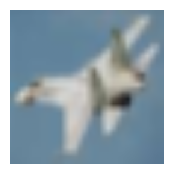

logits: tensor([ 28.4206, -13.9807,   6.6347,  -1.9783,   9.1473,  -2.2799,   5.7235,
        -13.8132,   7.5786, -18.9116], device='cuda:0',
       grad_fn=<SelectBackward0>)
probabilities: tensor([1.0000e+00, 3.8489e-19, 3.4556e-10, 6.2793e-14, 4.2632e-09, 4.6447e-14,
        1.3892e-10, 4.5508e-19, 8.8804e-10, 2.7791e-21], device='cuda:0',
       grad_fn=<SelectBackward0>)
predicted class: plane
label: plane


In [6]:
#CIFAR labels to human readable labels
CIFAR10_CLASSES = [
    'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
]
data = next(iter(test_loader))
images, labels = data

# Check the shape of the images and labels
print(f'Images shape: {images.shape}')
print(f'Labels shape: {labels.shape}')
def imshow(img):
    npimg = img.numpy()
    plt.figure(figsize=(2, 2))  # keep this small to avoid blur
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')  # no interpolation
    plt.axis('off')
    plt.show()

idx = 10
imshow(images[idx])

images = images.to(device)
y = model(images) # B, num_classes
print(f"logits: {y[idx]}")
pred = torch.nn.functional.softmax(y, dim=1) # B, num_classes
print(f"probabilities: {pred[idx]}")
pred = torch.argmax(pred, dim=1) # B
print(f"predicted class: {CIFAR10_CLASSES[pred[idx]]}")

print(f"label: {CIFAR10_CLASSES[labels[idx].item()]}")


